# ASTRO 533 - Project 6

**Created:** Oct. 2020   
**Last Edit:** Oct. 2020  

**Author:** Bill Chen  
**Email:** ybchen@umich.edu  

## Load packages and read data

In [158]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.table import Table as tb
import astropy.coordinates as coord
import astropy.units as u
from astropy.units import cds
import copy
plt.style.use('bill')

my_YlGnBu = copy.copy(mpl.cm.get_cmap('YlGnBu')) # copy the default cmap
my_YlGnBu.set_bad('w')

my_magma = copy.copy(mpl.cm.get_cmap('magma'))
my_magma.set_bad(my_magma(-1))

gaiarv_cat = tb.read('../Project_5/glt13_kin.fits', format='fits')

## Get dynamics

In [159]:
samp = gaiarv_cat[np.where( (gaiarv_cat['parallax'] < 1) & (gaiarv_cat['parallax'] > 2/3) )] # dist = 1 - 1.5 kpc

n_samp = len(samp)
print('Number of candidates:', n_samp)

Number of candidates: 597946


In [161]:
dist = coord.Distance(parallax=u.Quantity(samp['parallax']))
c = coord.SkyCoord(ra=samp['ra'],
                   dec=samp['dec'],
                   distance=dist,
                   pm_ra_cosdec=samp['pmra'],
                   pm_dec=samp['pmdec'],
                   radial_velocity=samp['radial_velocity'])

coord.Galactocentric()
galcen = c.transform_to(coord.Galactocentric(z_sun=15.3*u.pc,
                                             galcen_distance=8.18*u.kpc,
                                             galcen_v_sun=coord.CartesianDifferential(np.array([11.1,250.1,7.25]),unit=u.kilometer/u.second)))

samp['d'] = 1000*u.pc*u.mas / (samp['parallax']) # distance in pc
samp['absmag'] = samp['phot_g_mean_mag'] - 5*np.log10(samp['d']/10) # absolute magnitude

ind, = np.where( galcen.v_y.value > 60 )

In [162]:
# polar system
t = np.arctan(-galcen.y/galcen.x)
r = np.sqrt( galcen.x**2 + galcen.y**2 )

v_t = galcen.v_y*np.cos(t) + galcen.v_x*np.sin(t)
v_r = galcen.v_y*np.sin(t) - galcen.v_x*np.cos(t)

## Phase

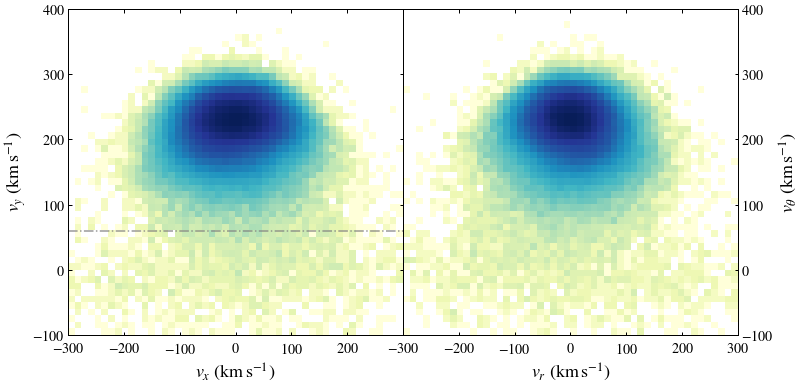

In [136]:
fig, [ax,ax2] = plt.subplots(1,2,figsize=(12,6), sharey=True)
fig.subplots_adjust(wspace=0)

ax.hist2d(galcen.v_x.value, galcen.v_y.value, range=[[-300, 300], [-100, 400]],
          bins = 50, norm=mcolors.LogNorm(), cmap=my_YlGnBu)
ax.axhline(60, c='gray', ls='-.', alpha=0.8)

ax.set_xlabel(r'$v_x\ (\mathrm{km\,s^{-1}})$')
ax.set_ylabel(r'$v_y\ (\mathrm{km\,s^{-1}})$')
ax.set_xlim(-300, 300)
ax.set_ylim(-100, 400)
ax.set_xticks([-300, -200, -100, 0, 100, 200])
ax.set_xticklabels([r'$-300$', r'$-200$', r'$-100$', r'$0$', r'$100$', r'$200$', r'$300$'])
ax.set_yticks([-100, 0, 100, 200, 300, 400])
ax.set_yticklabels([r'$-100$', r'$0$', r'$100$', r'$200$', r'$300$', r'$400$'])


ax2.hist2d(v_r.value, v_t.value, range=[[-300, 300], [-100, 400]],
           bins = 50, norm=mcolors.LogNorm(), cmap=my_YlGnBu)

ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.set_xlabel(r'$v_r\ (\mathrm{km\,s^{-1}})$')
ax2.set_ylabel(r'$v_\theta\ (\mathrm{km\,s^{-1}})$')
ax2.set_xticks([-300, -200, -100, 0, 100, 200, 300])
ax2.set_xticklabels([r'$-300$', r'$-200$', r'$-100$', r'$0$', r'$100$', r'$200$', r'$300$'])

plt.savefig('./figures/phase.pdf')
plt.show()

## $\beta$-factor

In [414]:
# based on v_x, v_y
beta1 = 1 - ( np.var(galcen.v_y[ind])/np.var(galcen.v_x[ind]) )
# beta1 = 1 - ( np.mean(galcen.v_y[ind]**2)/np.mean(galcen.v_x[ind]**2) )

# based on v_t, v_r
beta2 = 1 - ( np.var(v_t[ind].value)/np.var(v_r[ind].value) )
# beta2 = 1 - ( np.mean(v_t[ind].value**2)/np.mean(v_r[ind].value**2) )

print('beta1:', beta1)
print('beta2:', beta2)

beta1: 0.6042279953251319
beta2: 0.47238207530776344


## $\frac{d\ln n}{d\ln r}$

In [163]:
ind, = np.where( (galcen.v_y.value > 60) & (samp['absmag'] < 2) ) # absolute magnitude upper limit: 2
galcen_new = galcen[ind]
samp_new = samp[ind]

t_new = t[ind]
r_new = r[ind]
v_t_new = v_t[ind]
v_r_new = v_r[ind]

In [369]:
# random sample spheres

x = np.random.uniform(-1400, 1400, 500)
y = np.random.uniform(-1400, 1400, 500)

enclose, = np.where( (x**2+y**2 > 1100**2) & (x**2+y**2 < 1400**2) )
x = x[enclose]
y = y[enclose]

# phi = np.linspace(0, 1, 16)[:-1]
# x = 1250 * np.cos(phi*2*np.pi)
# y = 1250 * np.sin(phi*2*np.pi)

print('number of sample spheres:', len(x))

number of sample spheres: 153


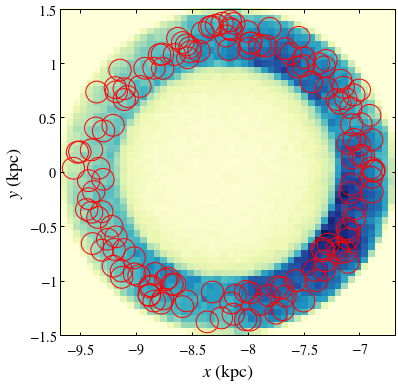

In [406]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(x)):
    ax.add_artist(Circle([x[i]-8180, y[i]], 100, facecolor='None', edgecolor='r'))

ax.hist2d(galcen_new.x.value, galcen_new.y.value, range=[[-8180-1500, -8180+1500], [-1500, 1500]],
          bins = 50, cmap=my_YlGnBu)

ax.set_xlabel(r'$x\ ({\rm kpc})$')
ax.set_ylabel(r'$y\ ({\rm kpc})$')
ax.set_xlim(-8180-1500, -8180+1500)
ax.set_ylim(-1500, 1500)
ax.set_xticks([-9500, -9000, -8500, -8000, -7500, -7000])
ax.set_xticklabels([r'$-9.5$', r'$-9$', r'$-8.5$', r'$-8$', r'$-7.5$', r'$-7$'])
ax.set_yticks([-1500, -1000, -500, 0, 500, 1000, 1500])
ax.set_yticklabels([r'$-1.5$', r'$-1$', r'$-0.5$', r'$0$', r'$0.5$', r'$1$', r'$1.5$'])

plt.savefig('./figures/sample.pdf')
plt.show()

In [415]:
rhos = np.zeros(len(x))
rs = np.zeros(len(x))
srs = np.zeros(len(x))

for i in range(len(x)):
    dx = -galcen_new.x.value-8180-x[i]
    dy = galcen_new.y.value-y[i]
    dz = galcen_new.z.value
    ind_samp1, = np.where( dx**2+dy**2+dz**2 < 250**2 )
    
    rhos[i] = len(ind_samp1) / (4*np.pi*(100**3)/3) # in pc^-3
    rs[i] = np.mean(r_new[ind_samp1].value) # in pc
    srs[i] = np.mean(v_r_new[ind_samp1].value**2) # in km^2 s^-2

k1: -2.7215098015902592
k2: -1.0198311121816526


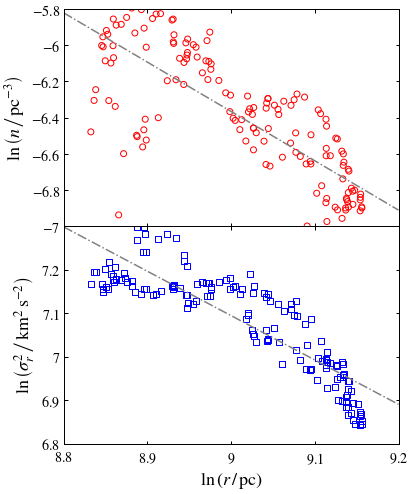

In [418]:
# plt.hist2d(galcen.x.value, galcen.y.value, bins=500);
# plt.scatter(-x-8180, y);


fig, [ax1,ax2] = plt.subplots(2,1,figsize=(6,8), sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(np.log(rs), np.log(rhos), edgecolor='r', marker='o', facecolor='None')
p = np.poly1d(np.polyfit(np.log(rs), np.log(rhos), 1))
ax1.plot([8.8, 9.2], p([8.8, 9.2]), c='gray', ls='-.')
k1 = p[1]
print('k1:', k1)

ax1.set_ylabel(r'$\ln\,\left(n\,\left/\,{\rm pc^{-3}}\right.\right)$')
ax1.set_xlim(8.8, 9.2)
ax1.set_ylim(-7, -5.8)
ax1.set_xticks([8.8, 8.9, 9, 9.1, 9.2])
ax1.set_xticklabels([r'$8.8$', r'$8.9$', r'$9$', r'$9.1$', r'$9.2$'])
ax1.set_yticks([-7, -6.8, -6.6, -6.4, -6.2, -6, -5.8])
ax1.set_yticklabels([r'$-7$', r'$-6.8$', r'$-6.6$', r'$-6.4$', r'$-6.2$', r'$-6$', r'$-5.8$'])

ax2.scatter(np.log(rs), np.log(srs), edgecolor='b', marker='s', facecolor='None')
p = np.poly1d(np.polyfit(np.log(rs), np.log(srs), 1))
ax2.plot([8.8, 9.2], p([8.8, 9.2]), c='gray', ls='-.')
k2 = p[1]
print('k2:', k2)

ax2.set_xlabel(r'$\ln\,(r\,\left/\,{\rm pc}\right.)$')
ax2.set_ylabel(r'$\ln\,\left(\left.\sigma_r^2\,\right/\,{\rm km^2\,s^{-2}}\right)$')
ax2.set_ylim(6.8, 7.3)
ax2.set_yticks([6.8, 6.9, 7, 7.1, 7.2, 7.3])
ax2.set_yticklabels([r'$6.8$', r'$6.9$', r'$7$', r'$7.1$', r'$7.2$'])

plt.savefig('./figures/rho_sr_r.pdf')
plt.show()

## Final estimate

In [417]:
vc1 = np.sqrt( - np.mean(v_r_new**2) * (2*beta1 + k1 + k2) )
print('vc1:', vc1)

vc2 = np.sqrt( - np.mean(v_r_new**2) * (2*beta2 + k1 + k2) )
print('vc2:', vc2)

vc1: 64.62971448043989 km / s
vc2: 67.91064889906629 km / s
